In [1]:
%run ./data/data.ipynb

Pulling data from sources.json:
(Source: CBS)  deceased @ https://opendata.cbs.nl/statline/portal.html?_catalog=CBS&_la=nl&tableId=70895ned&_theme=76
(Source: CBS)  population @ https://opendata.cbs.nl/statline/portal.html?_catalog=CBS&_la=nl&tableId=37230ned&_theme=76
(Source: RIVM) counts_per_municipality @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427
(Source: RIVM) prevalence @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/097155aa-75eb-4caa-8ed3-4c6edb80467e
(Source: RIVM) r @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/ed0699d1-c9d5-4436-8517-27eb993eab6e
(Source: RIVM) homes_for_elderly @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/0179dd26-7bf6-4021-857f-8623aaf8e73a
(Source: RIVM) homes_for_disabled @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/aa28b74d-7150-47bc-a7cb-98876e93381b
(Source: RIVM) seventy_plus_living_at_home @ https://data.riv

# Epyestim: application to Covid-19 data (tutorial)

Used by RIVM to model covid in Netherlands (https://www.rivm.nl/coronavirus-covid-19/hoe-berekeningen-bijdragen-aan-bestrijding-van-virus/rekenmodellen)

Pythonversion of the model is [epyestim](https://pypi.org/project/epyestim/)

This tutorial will guide you through basic applications of the `epyestim` package to Covid-19 data, provided by the module `covid19`. For a more general introduction to the package, check out the other tutorial notebooks.

__Contents__:

1. Estimating the effective reproduction number from reported cases
2. Estimating the effective reproduction number from deaths, hospitalisations or test dates instead of reported cases
3. Interpretation of results
4. Common issues

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%matplotlib inline

from scipy.stats import gamma, poisson

import epyestim
import epyestim.covid19 as covid19

## 1. Estimating the effective reproduction number from reported cases

In the standard use case, epyestim estimates the effective reproduction number from a time series of reported cases. (Other cases will be discussed in section 2.) The reproduction number is computed using the function

`covid19.r_covid(confirmed_cases, gt_distribution=generate_standard_si_distribution(), delay_distribution=generate_standard_delay_distribution(), a_prior=3, b_prior=1, smoothing_window=21, r_window_size=3, r_interval_dates=None, n_samples=100, quantiles=(0.025, 0.5, 0.975), auto_cutoff=True)`:

*Mandatory argument*:
* `confirmed_cases` (pandas.Series): the time series of confirmed cases

*Optional arguments*:
* `gt_distribution` (numpy.array): the generation time distribution (in days).
* `delay_distribution` (numpy.array): the distribution of delays (in days) from onset to reporting.
* `a_prior` (int): prior for the shape parameter of the Gamma distribution of the reproduction number
* `b_prior` (int): prior for the scale parameter of the Gamma distribution of the reproduction number
* `smoothing_window` (int): window size (in days) for the LOWESS smoothing of reported cases
* `r_window_size` (int): window size (in days) for final rolling average
* `r_interval_dates` (List[datetime.date]): time intervals for piece-wise constant reproduction number. If None, the time-varying reproduction number is computed instead.
* `n_samples` (int): number of bootstrap samples
* `quantiles` (Iterable[float]): quantiles of the posterior distribution of the reproduction number
* `auto_cutoff` (bool): estimates are only provided after 1. cumulative cases have reached at least 12, 2. at least one mean generation time has passed since the index case and 3., if applicable, at least one r_window_size has passed since the index case.

*Returns*:
* `out` (pandas.DataFrame): data frame with index dates and columns 'cases', 'R_mean', 'R_var' and all the R-quantiles from `quantiles`.

If you want piece-wise constant R over fixed time intervals, you must provide `r_interval_dates`, a list of interval boundaries in datetime.date format. It takes precedence over `r_window_size`.

### 1.1. The input series of reported cases

The time series has to be provided in the format of a pandas series with date intex. As an example we use the time series of reported Covid-19 cases from Switzerland (source: John Hopkins CSSE Covid-19 repository):

In [3]:
ch_cases = rivm_per_day['Positive_tests']

In [4]:
ch_cases = counts_per_municipality['Positive_tests'].reset_index()
ch_cases['Date'] = ch_cases['Date'].astype(str)
ch_cases['Date'] = pd.to_datetime(ch_cases['Date'])
ch_cases.set_index('Date',inplace=True)
ch_cases = ch_cases['Positive_tests']

### 1.2. The input distributions

You can skip this section if you are happy to use our default Covid-19 generation time distribution and reporting delay distribution.

There are two distributions involved in the calculation:
* The generation time distribution
* The distribution of delays from infection to reporting.

Both of them must be provided as numpy arrays. The index correspondnds to the delay (in days), the values to the relative frequencies. All values must be non-zero. (If your distribution has vanishing probability for instance for delay = 0 days, you must replace it with a small non-zero value.)

For Covid-19, we provide default values for both distributions:
* *Generation time distribution*: we provide the serial interval distribution (mean: 4.3 days) for Covid-19, as used by Flaxman et al., Nature 584, 257–261 (2020). https://doi.org/10.1038/s41586-020-2405-7
* *Delay distribution*: we provide a standard infection to reporting delay distribution (mean: 10.3 days), obtained as a convolution of the incubation time distribution and onset to reporting delay distribution as used by Brauner et al. (2020) preprint: https://www.medrxiv.org/content/10.1101/2020.05.28.20116129v4

They are accessed like so:

In [5]:
si_distrb = covid19.generate_standard_si_distribution()
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()

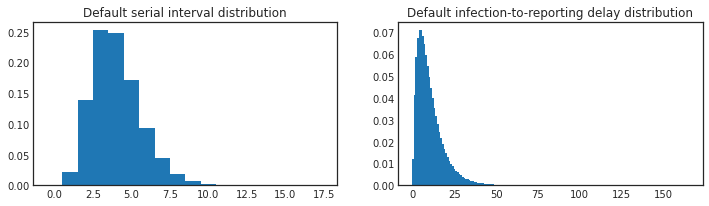

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))

axs[0].bar(range(len(si_distrb)), si_distrb, width=1)
axs[1].bar(range(len(delay_distrb)), delay_distrb, width=1)

axs[0].set_title('Default serial interval distribution')
axs[1].set_title('Default infection-to-reporting delay distribution')
plt.show()

One way to make your own distributions is to pick a standard continuous distribution from the scipy.stats package (an object of type `rv_continuous`) and discretise it by using our function `epyestim.discrete_distrb()`, like so:

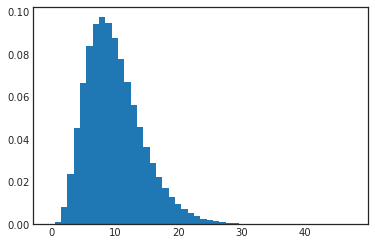

In [7]:
my_continuous_distrb = gamma(a=5, scale=2)
my_discrete_distrb = epyestim.discrete_distrb(my_continuous_distrb)

plt.bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1)
plt.show()

### 1.3. Estimating the time-varying R(t)

Let's estimate the time-varying effective reproduction number R(t) for Switzerland, using our default distributions and parameters:

In [8]:
ch_time_varying_r = covid19.r_covid(ch_cases)

ch_time_varying_r.tail()

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2021-10-20,4583.0,1.240486,0.000071,1.224103,1.240467,1.256975
2021-10-21,5178.0,1.237106,0.000067,1.221202,1.237088,1.253104
2021-10-22,5842.0,1.228658,0.000063,1.213196,1.228641,1.244214
2021-10-23,5672.0,1.213847,0.000059,1.198878,1.213831,1.228912
2021-10-24,6305.0,1.195105,0.000055,1.180592,1.195089,1.209705


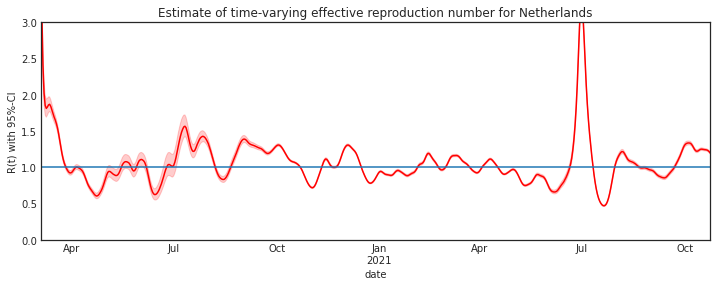

In [9]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index, 
                    ch_time_varying_r['Q0.025'], 
                    ch_time_varying_r['Q0.975'], 
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Netherlands')
plt.show()

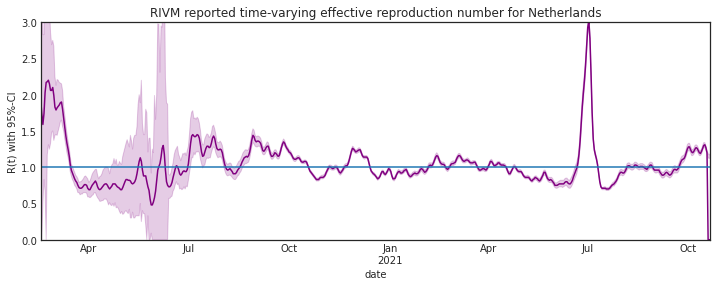

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

r.loc[:,'Rt_avg'].plot(ax=ax, color='purple')
ax.fill_between(r.index, 
                    r['Rt_low'], 
                    r['Rt_up'], 
                    color='purple', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('RIVM reported time-varying effective reproduction number for Netherlands')
plt.show()

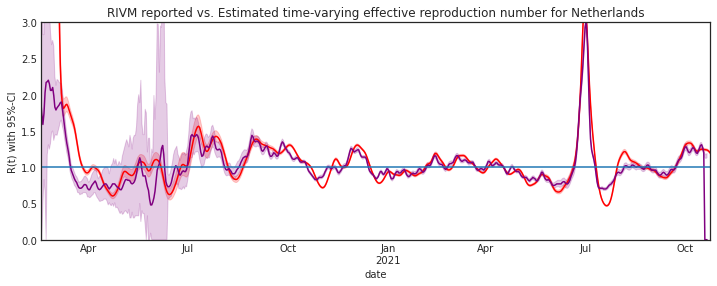

In [11]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index, 
                    ch_time_varying_r['Q0.025'], 
                    ch_time_varying_r['Q0.975'], 
                    color='red', alpha=0.2)
r.loc[:,'Rt_avg'].plot(ax=ax, color='purple')
ax.fill_between(r.index, 
                    r['Rt_low'], 
                    r['Rt_up'], 
                    color='purple', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('RIVM reported vs. Estimated time-varying effective reproduction number for Netherlands')
plt.show()

### 1.4. Estimating piece-wise constant R

Let's compute the average effective reproduction number for Switzerland in the following time intervals (chosen to roughly coincide with the introduction/suspension of national non-pharmaceutical interventions):

In [12]:
from datetime import date

time_intervals = [date(2020, 3, 2), date(2020, 3, 13), date(2020, 3, 17), date(2020, 3, 21),
                  date(2020, 4, 23), date(2020, 5, 10), date(2020, 5, 31), date(2020, 6, 7),
                  date(2020, 6, 15), date(2020, 6, 23), date(2020, 7, 6), date(2020, 9, 30),
                  date(2020, 10, 19), date(2020, 11, 4), date(2020, 11, 9), date(2020, 12, 1), date(2020, 12, 22), date(2021, 2, 9), date(2021, 3, 30)] 

In [13]:
ch_piecewise_r = covid19.r_covid(ch_cases, r_interval_dates = time_intervals)

ch_piecewise_r

/home/cjvanzwol/miniconda3/envs/covid/lib/python3.9/site-packages/epyestim/main.py:126: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if r_interval_dates[0] < start_cutoff_date:
/home/cjvanzwol/miniconda3/envs/covid/lib/python3.9/site-packages/epyestim/main.py:127: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  r_interval_dates = [start_cutoff_date] + [d for d in r_interval_dates if d > start_cutoff_date]
/home/cjvanzwol/miniconda3/envs/covid/lib/python3.9/site-packages/epyestim/main.py:128: UserWarning: First interval start reset to 2020-03-04 00:00:00. If you do not want that, set auto_cuto

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-03-04,10,1.939446,0.001407,1.865822,1.939197,2.014871
2020-03-05,17,1.939446,0.001407,1.865822,1.939197,2.014871
2020-03-06,40,1.939446,0.001407,1.865822,1.939197,2.014871
2020-03-07,50,1.939446,0.001407,1.865822,1.939197,2.014871
2020-03-08,32,1.939446,0.001407,1.865822,1.939197,2.014871
...,...,...,...,...,...,...
2021-10-20,4583,NaN,NaN,NaN,NaN,NaN
2021-10-21,5178,NaN,NaN,NaN,NaN,NaN
2021-10-22,5842,NaN,NaN,NaN,NaN,NaN
2021-10-23,5672,NaN,NaN,NaN,NaN,NaN


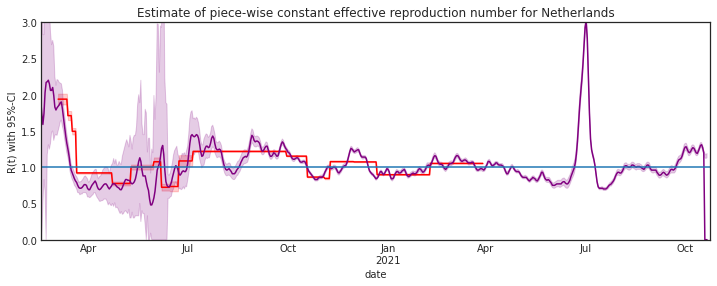

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_piecewise_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_piecewise_r.index, 
                    ch_piecewise_r['Q0.025'], 
                    ch_piecewise_r['Q0.975'], 
                    color='red', alpha=0.2)
r.loc[:,'Rt_avg'].plot(ax=ax, color='purple')
ax.fill_between(r.index, 
                    r['Rt_low'], 
                    r['Rt_up'], 
                    color='purple', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of piece-wise constant effective reproduction number for Netherlands')
plt.show()

### 1.5. Custom options

We have already seen how to customise the generation time distribution and reporting delay distribution. Let's look at some of the other optional arguments of `covid19.r_covid()`.

**1.5.1. Smoothing options**

The argument `smoothing_window` controls the degree to which the initial case numbers are smoothed in order to account for spurious effects in the reporting process, such as reporting spikes due to backlog of cases, weekend patterns, etc.

With the default value `smoothing_window=21`, initial case numbers are LOWESS-smoothed with a time window of 21 days. This is rather long, so let's check what happens if we smooth with a window of 7 days instead:

In [ ]:
ch_time_varying_r_ = covid19.r_covid(ch_cases, smoothing_window=7)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r_.loc[:,'Q0.5'].plot(ax=ax, color='orange')
ax.fill_between(ch_time_varying_r_.index, 
                    ch_time_varying_r_['Q0.025'], 
                    ch_time_varying_r_['Q0.975'], 
                    color='orange', alpha=0.2)
r.loc[:,'Rt_avg'].plot(ax=ax, color='purple')
ax.fill_between(r.index, 
                    r['Rt_low'], 
                    r['Rt_up'], 
                    color='purple', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Netherlands')
plt.show()

Obviously, this window is too small and tends to exacerbate weekly patterns rather than smooth them out (remember that the LOWESS algorithm weights values in the middle of the window much higher than at the edge of it). To a lesser extent we still see these fluctuations if we set `smoothing_window`. However, we can compensate for some of that by choosing `r_window_size=7`, which averages the final output over 7 days:

In [ ]:
ch_time_varying_r_ = covid19.r_covid(ch_cases, smoothing_window=14, r_window_size=7)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r_.loc[:,'Q0.5'].plot(ax=ax, color='orange')
ax.fill_between(ch_time_varying_r_.index, 
                    ch_time_varying_r_['Q0.025'], 
                    ch_time_varying_r_['Q0.975'], 
                    color='orange', alpha=0.2)
r.loc[:,'Rt_avg'].plot(ax=ax, color='purple')
ax.fill_between(r.index, 
                    r['Rt_low'], 
                    r['Rt_up'], 
                    color='purple', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Netherlands')
plt.show()

**1.5.2. Speed it up**

If speed is an issue, you can reduce the number of bootstrap samples, for example to `n_samples=10`. The loss in accuracy tends to be not very significant:

In [ ]:
ch_time_varying_r_100samples = covid19.r_covid(ch_cases, n_samples=100, r_window_size=1)
ch_time_varying_r_10samples = covid19.r_covid(ch_cases, n_samples=10, r_window_size=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r_100samples.loc[:,'Q0.5'].plot(ax=ax, color='black', label='100 samples')
ch_time_varying_r_10samples.loc[:,'Q0.5'].plot(ax=ax, color='red', label='10 samples')
r.loc[:,'Rt_avg'].plot(ax=ax, color='purple', label='rivm')
ax.set_xlabel('date')
ax.set_ylabel('R(t)')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.legend()
ax.set_title('Estimate of time-varying effective reproduction number for Netherlands')
plt.show()

**1.5.3. Show uncut R(t)**

If you want to show the estimate for R(t) before the conditions of Cori et al. for reliable estimation are met, you can set `auto_cutoff=False`:

In [ ]:
ch_time_varying_r_ = covid19.r_covid(ch_cases, auto_cutoff=False)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r_.loc[:,'Q0.5'].plot(ax=ax, color='green')
ax.fill_between(ch_time_varying_r_.index, 
                    ch_time_varying_r_['Q0.025'], 
                    ch_time_varying_r_['Q0.975'], 
                    color='green', alpha=0.2)
r.loc[:,'Rt_avg'].plot(ax=ax, color='purple')
ax.fill_between(r.index, 
                    r['Rt_low'], 
                    r['Rt_up'], 
                    color='purple', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Netherlands')
plt.show()

*Note*: if you do use the default `auto_cutoff=True`, keep in mind that this is a rather minimal cutoff. Depending on the data at hand, you might have to cut off more days at the beginning until you get a reliable estimate.

**1.5.4. Different confidence bands**

If you want to get different confidence bands, you can change `quantiles`:

In [ ]:
ch_time_varying_r_ = covid19.r_covid(ch_cases, quantiles=(0.025, 0.25, 0.5, 0.75, 0.975))
ch_time_varying_r_

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r_.loc[:,'Q0.5'].plot(ax=ax, color='brown')
ax.fill_between(ch_time_varying_r_.index, 
                    ch_time_varying_r_['Q0.25'], 
                    ch_time_varying_r_['Q0.75'], 
                    color='brown', alpha=0.2)
ax.fill_between(ch_time_varying_r_.index, 
                    ch_time_varying_r_['Q0.025'], 
                    ch_time_varying_r_['Q0.975'], 
                    color='brown', alpha=0.1)
r.loc[:,'Rt_avg'].plot(ax=ax, color='purple')
ax.fill_between(r.index, 
                    r['Rt_low'], 
                    r['Rt_up'], 
                    color='purple', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 50%-CI and 95%-CI')
ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Estimate of time-varying effective reproduction number for Netherlands')
plt.show()

Remember that you can also always get the mean and variance by accessing the `"R_mean"`and `"R_var"` columns in the output dataframe of `covid19.r_covid()`.

## 2. Estimating the effective reproduction number from deaths, hospitalisations or test dates instead of reported cases

If your input series contains dates of positive test, hospitalisations, death dates or reported deaths instead of reported confirmed cases, you can still use the function `covid19.r_covid()`. However, you must provide the `delay_distribution` which is appropriate to the data you have (i.e. the distribution of delays from onset of symptoms to the event registered by your data). See section 1.2. for how to make your own distribution.

For instance, if your data contains death dates, you need to provide a distribution of delays from onset to death.

Moreover, you might want to optimise `smoothing_window` and `r_window_size` for your application.

## 3. Interpretation of results

We encourage everybody to have a closer look at the methodology used:
* For R-estimation from infection dates (the paper incl. R package 'epiestim'): Anne Cori, Neil M. Ferguson, Christophe Fraser, Simon Cauchemez, A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, American Journal of Epidemiology, Volume 178, Issue 9, 1 November 2013, Pages 1505–1512, https://doi.org/10.1093/aje/kwt133
* For inference of infection dates from reporting dates, see the preprint (incl. R implementation) by Huisman et al., https://ibz-shiny.ethz.ch/covid-19-re/methods.pdf

Here, we just point out some essential things to keep in mind when interpreting the results.

### 3.1. Infection data versus reporting data

Epyestim is built to estimate the effective reproduction number based on reporting numbers (be it reported cases, deaths or any other event that follows infection). Obviously, this yields less precise estimates than could be obtained if actual infection times were known. To understand the difference in accuracy, let us create some synthetic infection data:

In [ ]:
true_r = pd.Series(
    [2.0] * 30 + [0.9] * 30 + [0.7] * 30,
    index=pd.date_range(start='2020-03-01', periods=90)
)

In [ ]:
fig, ax = plt.subplots()
true_r.plot(ax=ax, color='blue')
r['Rt_avg'].plot(ax=ax, color='purple')
ax.set_title("True reproduction number")
plt.show()

In [ ]:
def _synthetic_infections(seed, r_ts):
    assert len(seed) == len(si_distrb)

    generated_incidence = seed[:]
    for r in r_ts:
        mu = r * sum(p * i for i, p in zip(si_distrb[1:], generated_incidence[::-1]))
        generated_incidence.append(
            poisson(mu=mu).rvs()
        )

    return pd.Series(generated_incidence[len(seed):], index=r_ts.index)

In [ ]:
incidence_ts = _synthetic_infections(
    seed=[1, 0, 1, 0, 2, 1, 3, 4, 4, 5, 7, 4, 8, 8, 3, 10, 0, 11], r_ts=true_r
)
synthetic_incidence_rivm = _synthetic_infections(
    seed=[1, 0, 1, 0, 2, 1, 3, 4, 4, 5, 7, 4, 8, 8, 3, 10, 0, 11], r_ts=r['Rt_avg']
)

In [ ]:
fig, ax = plt.subplots()
incidence_ts.plot(ax=ax)
synthetic_incidence_rivm.plot(ax=ax, color='purple')
#rivm_per_day['Positive_tests'].plot(ax=ax)
ax.set_ylabel("Daily infections")
ax.set_title("True incidence")
plt.show()

Now let's create a time series of reported confirmed cases from these true infection data. We use convolution by the standard delay distribution to obtain the expected number of confirmed cases on each day, and then add some noise and a weekly pattern to it:

In [ ]:
import scipy.linalg as la

col = delay_distrb[:90]
row = np.concatenate(([delay_distrb[0]], np.zeros(89)), axis=None)

delay_kernel = la.toeplitz(col, row)
        
plt.imshow(delay_kernel[:,:], cmap='viridis')
plt.show()

In [ ]:
confirmed_expected = delay_kernel @ incidence_ts
confirmed_noise = np.random.normal(0, 1, size=90)/10
week_pattern = np.sin(2*np.pi*np.arange(90)/7)/5
#confirmed_cases = pd.Series(confirmed_expected*(1 + confirmed_noise + week_pattern), index=incidence_ts.index).astype(int)

In [ ]:
rivm_per_day

In [ ]:
fig, ax = plt.subplots()
incidence_ts.plot(ax=ax, label='infected_ts')
confirmed_cases.plot(ax=ax, label='confirmed_ts')
synthetic_incidence_rivm.plot(ax=ax, label='synthetic_incidence_rivm')
rivm_per_day['Positive_tests'].plot(ax=ax, label='RIVM positive tests', color='purple')
#rivm_per_day['prev_avg'].plot(ax=ax, label='RIVM positive tests', color='purple')
ax.set_ylabel("Daily infections and confirmed cases")
ax.legend()
plt.show()

Now let's compare direct estimation of R from the infection time series with indirect estimation from the time series of reported cases. (The direct estimation is invoked by the function `epyestim.estimate_r.estimate_r()` which outputs the shape and scale of the gamma posterior distributions. We use the function `epyestim.estimate_r.gamma_quantiles()` to extract the confidence intervals. Feel free to check out the code...).

In [ ]:
r_direct = dict()
r_indirect = dict()

for r_window_size in [1, 3, 7]:
    
    # direct estimate from the infection data
    r_direct[r_window_size] = epyestim.estimate_r.estimate_r(
        infections_ts = incidence_ts,
        gt_distribution = si_distrb,
        a_prior = 3,
        b_prior = 1,
        window_size = r_window_size
    )
    for q in [0.025, 0.5, 0.975]:
        r_direct[r_window_size][f'Q{q}'] = epyestim.estimate_r.gamma_quantiles(q, r_direct[r_window_size]['a_posterior'], 
                                                                               r_direct[r_window_size]['b_posterior'])
    
    # indirect estimate from the reporting data
    r_indirect[r_window_size] = covid19.r_covid(
        confirmed_cases,
        smoothing_window = 21,
        r_window_size = r_window_size,
        auto_cutoff = False
    )

In [ ]:
rivm_direct = dict()
rivm_indirect = dict()

for r_window_size in [1, 3, 7]:
    
    # direct estimate from the infection data
    rivm_direct[r_window_size] = epyestim.estimate_r.estimate_r(
        infections_ts = rivm_per_day['Positive_tests'].dropna(),
        gt_distribution = si_distrb,
        a_prior = 3,
        b_prior = 1,
        window_size = r_window_size
    )
    for q in [0.025, 0.5, 0.975]:
        rivm_direct[r_window_size][f'Q{q}'] = epyestim.estimate_r.gamma_quantiles(q, rivm_direct[r_window_size]['a_posterior'], 
                                                                               rivm_direct[r_window_size]['b_posterior'])
    
    # indirect estimate from the reporting data
    rivm_indirect[r_window_size] = covid19.r_covid(
        confirmed_cases,
        smoothing_window = 21,
        r_window_size = r_window_size,
        auto_cutoff = False
    )

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20.48, 5))

for i, windows in enumerate(r_direct.keys()):
    ax = axs[i]
    r_direct[windows].loc[:,'Q0.5'].plot(ax=ax, color='black', label='from infection dummy data')
    ax.fill_between(r_direct[windows].index, 
                    r_direct[windows]['Q0.025'], 
                    r_direct[windows]['Q0.975'], 
                    color='grey', alpha=0.2)
    r_indirect[windows].loc[:,'Q0.5'].plot(ax=ax, color='red', label='from reporting dummy data')
    ax.fill_between(r_indirect[windows].index, 
                    r_indirect[windows]['Q0.025'], 
                    r_indirect[windows]['Q0.975'], 
                    color='red', alpha=0.2)
    true_r.plot(ax=ax, label='true R')
    rivm_direct[windows].loc[:,'Q0.5'].plot(ax=ax, color='green', label='from infection data')
    ax.fill_between(rivm_direct[windows].index, 
                    rivm_direct[windows]['Q0.025'], 
                    rivm_direct[windows]['Q0.975'], 
                    color='green', alpha=0.2)
    rivm_indirect[windows].loc[:,'Q0.5'].plot(ax=ax, color='blue', label='from reporting data')
    ax.fill_between(rivm_indirect[windows].index, 
                    rivm_indirect[windows]['Q0.025'], 
                    rivm_indirect[windows]['Q0.975'], 
                    color='blue', alpha=0.2)
    r.loc[:,'Rt_avg'].plot(ax=ax, color='purple')
    ax.fill_between(r.index, 
                    r['Rt_low'], 
                    r['Rt_up'], 
                    color='purple', alpha=0.2)
    ax.set_ylim([0,4])
    ax.set_xlim([date(2020, 3, 1), date(2021, 3, 29)])
    ax.set_title(f'R-window = {windows}')
    ax.legend()

plt.show()

This comparison shows that estimating R form reported data tends to give pretty accurate results (provided we use the correct serial interval and delay distribution) *if* R does not change abruptly. Rapid changes are only fully absorbed with a delay of around `smoothing_window/2`, which amounts to 10 days in our default settings.

Note also, that an accurate estimate of R can not be expected in the 10 days or so prior to the last data point, since only a fraction of infections occuring in that time frame will have been reported already. The deconvolution algorithm which infers the infections from the reported cases does in principle take that into account. However, the uncertainity of the estimate during that time period increases, and our confidence intervals do not reflect that. Hence, by default (`auto_cutoff=True`) the estimates are cut off at one mean delay (from the input `delay_distribution`) before the end of the time series.

### 3.2. The influence of the distributions on the result

It should be noted that use of an incorrect generation time distribution will lead to a systematic bias of the estimate. For instance, let's redo the above comparison using a different generation time distribution (mean = 7 days instead of 4 days, both values which have been suggested in the literature):

In [ ]:
alternative_si_distrb = epyestim.discrete_distrb(gamma(a=10, scale=0.7))

plt.bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1)
plt.show()

In [ ]:
r_indirect_ = dict()

for r_window_size in [1, 3, 7]:
    r_indirect_[r_window_size] = covid19.r_covid(
        confirmed_cases,
        gt_distribution = alternative_si_distrb,
        smoothing_window = 21,
        r_window_size = r_window_size,
        auto_cutoff = False
    )

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20.48, 5))

for i, windows in enumerate(r_direct.keys()):
    ax = axs[i]
    r_direct[windows].loc[:,'Q0.5'].plot(ax=ax, color='black', label='from infection data')
    ax.fill_between(r_direct[windows].index, 
                    r_direct[windows]['Q0.025'], 
                    r_direct[windows]['Q0.975'], 
                    color='grey', alpha=0.2)
    r_indirect_[windows].loc[:,'Q0.5'].plot(ax=ax, color='orange', label='from reporting data')
    ax.fill_between(r_indirect_[windows].index, 
                    r_indirect_[windows]['Q0.025'], 
                    r_indirect_[windows]['Q0.975'], 
                    color='orange', alpha=0.2)
    true_r.plot(ax=ax, label='true R')
    ax.set_ylim([0,4])
    ax.set_xlim([date(2020, 3, 1), date(2020, 5, 29)])
    ax.set_title(f'R-window = {windows}')
    ax.legend()

plt.show()

We see that using too long a generation time leads to overestimation in the range R>1 and underestimation in the range R<1. This underscores the importance of using accurate generation time distributions. However, it should be kept in mind that these distributions can change over the course of the epidemic. Our package currently does not support time-varying distributions.

Finally, let's also do the same comparison with an alternative reporting delay distribution (based on same incubation period distribution, but different onset to reporting delay distribution as found for Singapore in early 2020 by Tariq et al., BMC Med 18, 166 (2020). https://doi.org/10.1186/s12916-020-01615-9):

In [ ]:
alternative_onset_to_reporting_distrb = covid19.generate_standard_incubation_time_distribution()
covid19.generate_onset_to_reporting_distribution_singapore()
alternative_delay_distrb = np.convolve(covid19.generate_standard_incubation_time_distribution(),
                                       alternative_onset_to_reporting_distrb)

plt.bar(range(len(alternative_delay_distrb)), alternative_delay_distrb, width=1)
plt.show()

In [ ]:
r_indirect_ = dict()

for r_window_size in [1, 3, 7]:
    r_indirect_[r_window_size] = covid19.r_covid(
        confirmed_cases,
        delay_distribution = alternative_delay_distrb,
        smoothing_window = 21,
        r_window_size = r_window_size,
        auto_cutoff = False
    )

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20.48, 5))

for i, windows in enumerate(r_direct.keys()):
    ax = axs[i]
    r_direct[windows].loc[:,'Q0.5'].plot(ax=ax, color='black', label='from infection data')
    ax.fill_between(r_direct[windows].index, 
                    r_direct[windows]['Q0.025'], 
                    r_direct[windows]['Q0.975'], 
                    color='grey', alpha=0.2)
    r_indirect_[windows].loc[:,'Q0.5'].plot(ax=ax, color='green', label='from reporting data')
    ax.fill_between(r_indirect_[windows].index, 
                    r_indirect_[windows]['Q0.025'], 
                    r_indirect_[windows]['Q0.975'], 
                    color='green', alpha=0.2)
    true_r.plot(ax=ax, label='true R')
    ax.set_ylim([0,4])
    ax.set_xlim([date(2020, 3, 1), date(2020, 5, 29)])
    ax.set_title(f'R-window = {windows}')
    ax.legend()

plt.show()

We see: for the most part, the estimate is less sensitive to the delay distribution than to the generation time distribution.

## 4. Common issues

### 4.1. AssertionError: deconvolution has nan in iteration X

This error happens if there are very long streaks of zeros in your data *after* an outbreak (zeros at the beginning get ignored or cut off, respectively). Here is a baby example (the time series for the cruise ship 'Diamond Princess'):

In [ ]:
cases = [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 61,
        0,  3, 71,  0, 40,  0, 43, 67, 70, 99, 88, 79, 13,  0,  0, 57,  0,
        0, 14,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]

example_series = pd.Series(cases, index=pd.date_range(date(2020,1,22), periods=238))

try:
    example_r = covid19.r_covid(example_series, smoothing_window=1, r_window_size=1)
    print('Everything worked fine!')
except AssertionError as err:
    print(f'AssertionError: {err}')

This is easily resolved by cutting the tail of the series (but we avoid automatising it due to potential unwanted side effects):

In [ ]:
example_series_ = example_series[:-100]
try:
    example_r = covid19.r_covid(example_series_, smoothing_window=1, r_window_size=1)
    print('Everything worked fine!')
except AssertionError as err:
    print(f'AssertionError: {err}')